# Slate Star Codex Reader Survey 2018

If you enjoy this, let's connect on LinkedIn:

https://www.linkedin.com/in/vincefavilla/

I'm a psychology professor and machine learning engineer. Also, I'm in the SF Bay Area and looking for a job outside of academia. :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from warnings import filterwarnings
filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I switch between two versions of the data:

- Both versions removed invalid answers, such as using text for a question that expected a numeric answer. The downside here is that it's too time-consuming to read responses and replace them with the intentions of the respondent (e.g., replacing "100k" with "100000"). So we're losing some data in the process


- The "inferred" data goes a step further and uses machine learning to estimate missing values (recall that it was a long survey and not everyone completed it). For the most part, this technique was quite effective, and I simply used the median value when the technique didn't work.

I use the basic ("cleaned") dataset when drawing comparisons between different segments of the SSC community. For example, I might compare the agreeableness (empathy) of liberals and conservatives. I don't think it's right to use estimated data for a task like this; let's stick to what the facts are.

In [2]:
# Inferred data (uses machine learning to estimate missing values)
data = pd.read_csv('ssc2018public_inferred.csv')

data = data[[i for i in data.columns if 'Unnamed' not in i]]

print('Data has', data.shape[0], 'responses and', data.shape[1], 'features')

Data has 7260 responses and 838 features


# Demographics

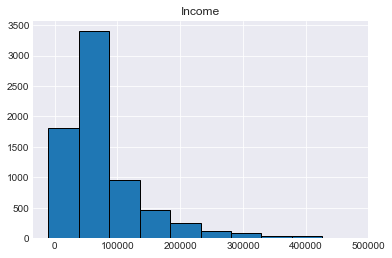

In [3]:
# Income
data[data.Income < 500000].Income.hist(edgecolor='black') # Remove the wealthy outliers
plt.title('Income')

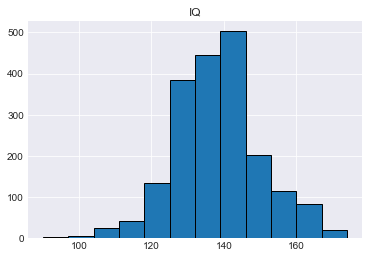

In [4]:
# IQ (excluding the missing values, which I replaced with the median)
data[data.IQ != data.IQ.median()].IQ.hist(edgecolor='black', bins=12)

plt.title('IQ')

We can normalize the SAT scores to account for which version of the test people took. We have a lot of really smart people in this community.

As a side note, whenever you see code along the lines of `!= .median()`, it means I'm removing the missing data I couldn't reasonably predict.

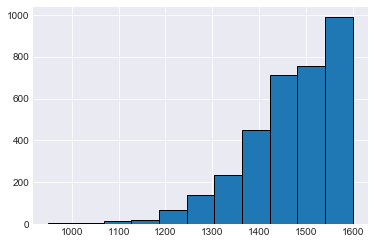

In [5]:
sat = np.where(data.SATscoresoutof1600 != data.SATscoresoutof1600.median(), data.SATscoresoutof1600/1600, np.nan)
sat = np.where(data.SATscoresoutof2400 != data.SATscoresoutof2400.median(), data.SATscoresoutof2400/2400, sat)

sat = pd.Series(sat) * 1600

sat[sat > 900].hist(edgecolor='black', bins=11)

One of my favorite things about the rationalist community is we tend to assume we're average unless we have strong evidence otherwise...

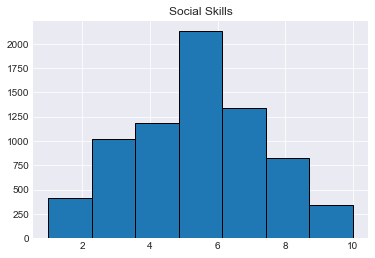

In [6]:
data.SocialSkills.hist(edgecolor='black', bins=7)
plt.title('Social Skills')

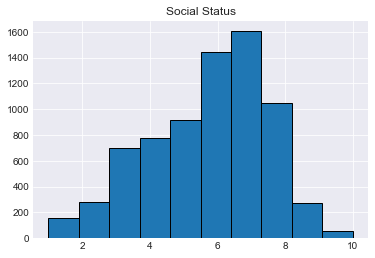

In [7]:
data.Status.hist(edgecolor='black', bins=10)
plt.title('Social Status')

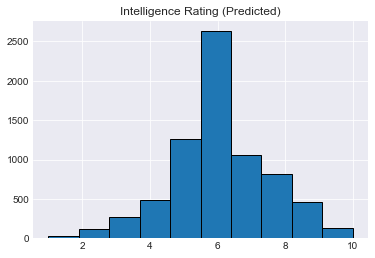

In [8]:
# "How intelligent do you think you are compared to the average reader of this blog?"
data.Percentile.hist(edgecolor='black', bins=10)

# I replaced missing values with the median -- and kept it -- 
# so this graph is a little more peaky than the others.
plt.title('Intelligence Rating (Predicted)')

Let's graph IQ vs. how people think they stack up against fellow SSC readers.

Correlation: 0.254


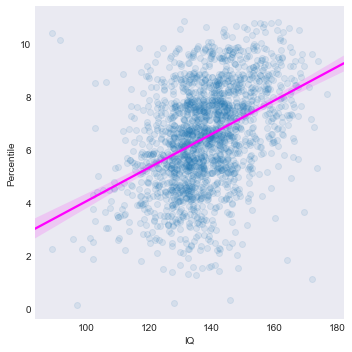

In [9]:
print('Correlation:', round(np.corrcoef(data.Percentile, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Percentile', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

The Dunning-Kruger effect is in full force in the top left. They're probably trolls. There are also a handful of very underconfident geniuses.

The relationship between IQ and social status is not as pronounced...

Correlation: 0.105


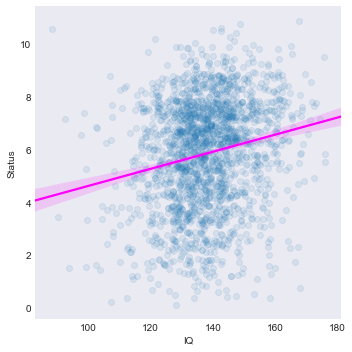

In [10]:
print('Correlation:', round(np.corrcoef(data.Status, data.IQ)[0,1], 3))

sns.lmplot('IQ', 'Status', data=data[data.IQ != data.IQ.median()],
            y_jitter=.9, x_jitter=3, scatter_kws={'alpha':.1}, line_kws={'color': 'magenta'})

# Life Outcomes

Let's look at the correlates for:

- RomanticLife
- FinancialSituation & Income
- LifeSatisfaction & MoodScale

The usual warning of correlation does not equal causation applies.

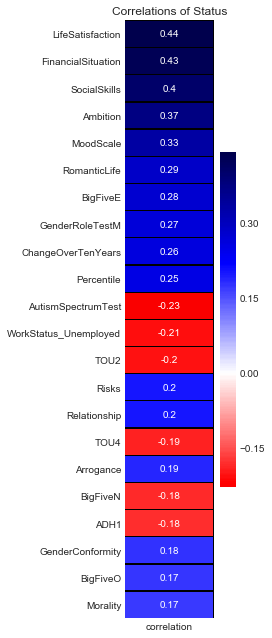

In [11]:
def absolute_correlations(col, df=data, ascending=False):
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    if ascending == False:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).tail(len(corrs)-1)
    else:
        return corrs.sort_values('absol', ascending=ascending).drop('absol', axis=1).head(len(corrs)-1)

def corrmap(df, cutoff=0.2, title='Correlations'):
    top_corrs = df[abs(df.correlation) > cutoff]
    plt.figure(figsize=(2,len(top_corrs)//2))
    plt.title(title)
    sns.heatmap(top_corrs, annot=True, fmt='.2g', cmap='seismic_r',
                center=0, linecolor='black', linewidths=.25)

# Status
status = absolute_correlations('Status', ascending=False)
corrmap(status, cutoff=.17, title='Correlations of Status')

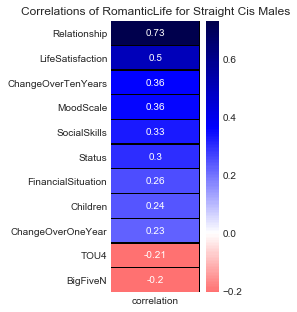

In [12]:
# Romantic life for straight cis males
scm = data[(data['Gender_M (cisgender)'] == 1) & (data['SexualOrientation_Heterosexual']) & (data['Sex_Male'] == 1)]

status = absolute_correlations('RomanticLife', df=scm, ascending=False)
corrmap(status, cutoff=.20, title='Correlations of RomanticLife for Straight Cis Males')

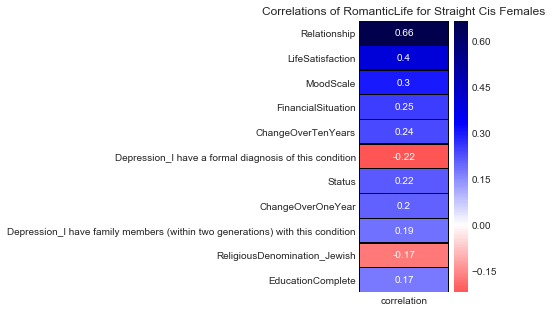

In [13]:
# Romantic life for straight cis females
scf = data[(data['Gender_F (cisgender)'] == 1) & data['SexualOrientation_Heterosexual'] & (data['Sex_Female'] == 1)]

status = absolute_correlations('RomanticLife', df=scf, ascending=False)
corrmap(status, cutoff=.17, title='Correlations of RomanticLife for Straight Cis Females')

In the interest of saving space, I won't run this analysis for LGBT community members. But I'm happy to move it to a separate notebook if there's enough demand.

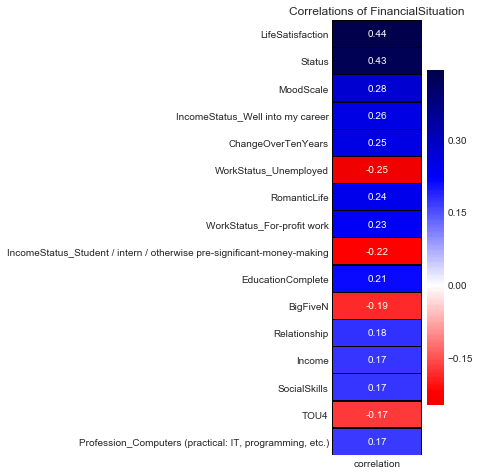

In [14]:
# FinancialSituation
finances = absolute_correlations('FinancialSituation', ascending=False)
corrmap(finances, cutoff=.17, title='Correlations of FinancialSituation')

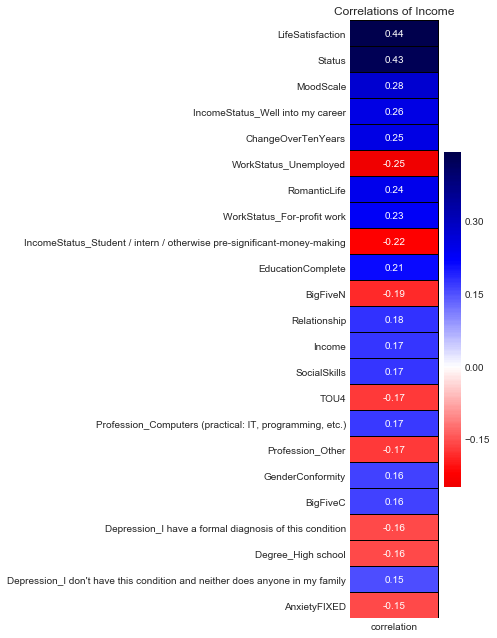

In [15]:
# Income

# This is a power law distribution so we should take the log
data['Log_income'] = np.log1p(data['Income'])

income = absolute_correlations('Log_income', df=data, ascending=False)
corrmap(finances, cutoff=.15, title='Correlations of Income')

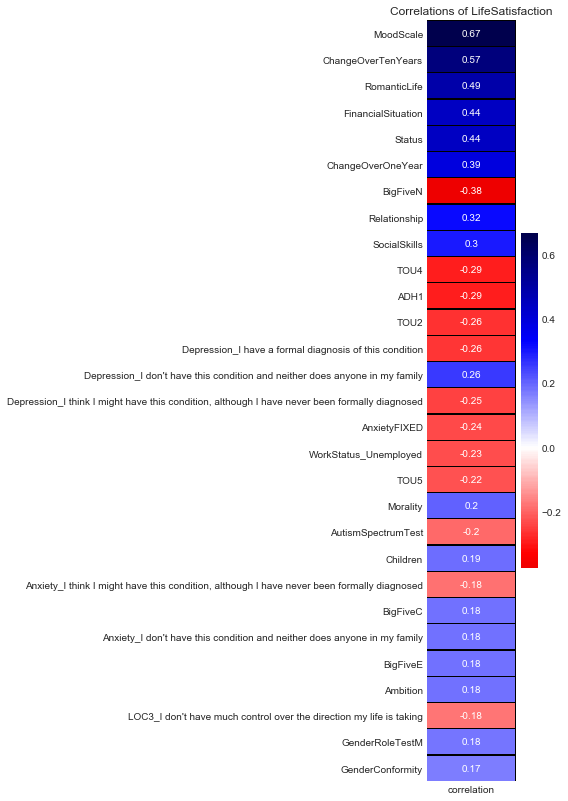

In [16]:
# LifeSatisfaction
satisfaction = absolute_correlations('LifeSatisfaction', ascending=False)
corrmap(satisfaction, cutoff=.17, title='Correlations of LifeSatisfaction')

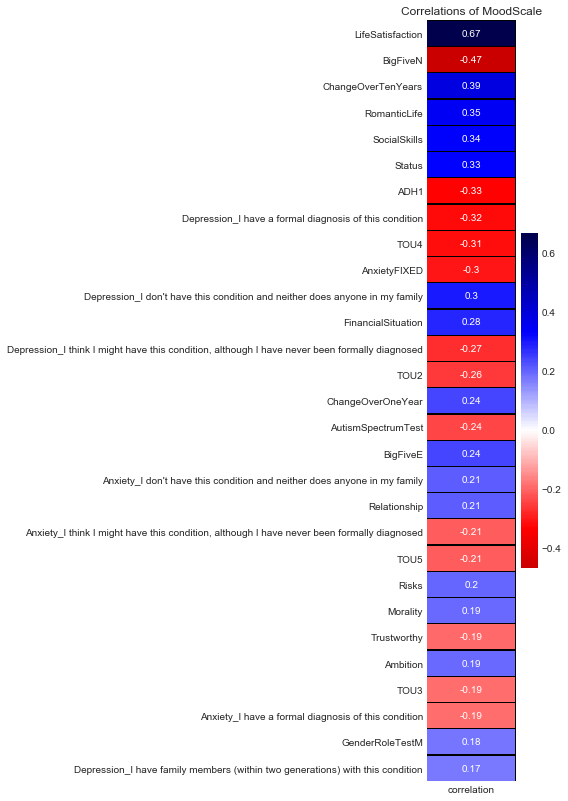

In [17]:
# MoodScale
mood = absolute_correlations('MoodScale', ascending=False)
corrmap(mood, cutoff=.17, title='Correlations of MoodScale')

# Personality

I think kdeplots look a bit better than histograms for graphing the big five personality traits. The distributions are a bit wonky, but a kdeplot can smooth them out and give us a better idea of what the population probably looks like.

Reminder: I used machine learning to estimate one's personality when the data wasn't available. It worked fairly well.

In [18]:
men = data[data['Gender_M (cisgender)'] == 1]
women = data[data['Gender_F (cisgender)'] == 1]

print(men.shape[0], 'men and', women.shape[0], 'women')

6330 men and 653 women


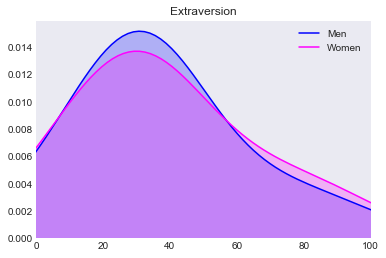

In [19]:
# No gender difference
sns.kdeplot(men['BigFiveE'], bw=18, color='blue', shade=True)
sns.kdeplot(women['BigFiveE'], bw=18, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Extraversion')

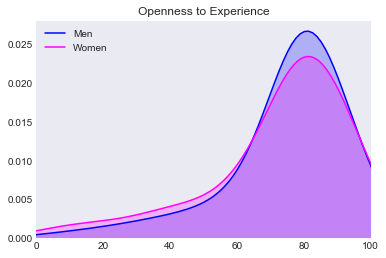

In [20]:
# No gender difference
sns.kdeplot(men['BigFiveO'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveO'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Openness to Experience')

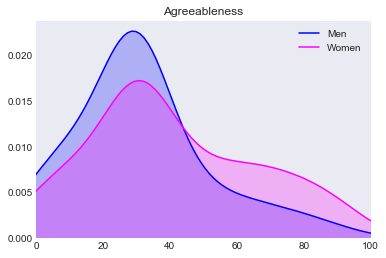

In [21]:
# Big difference here
sns.kdeplot(men['BigFiveA'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveA'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Agreeableness')

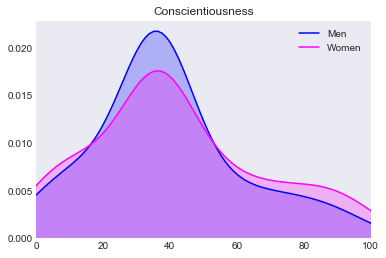

In [22]:
# It looks like women score higher here, and often they do,
# but it's hard to say definitively. We need more people to take the test.

sns.kdeplot(men['BigFiveC'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveC'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Conscientiousness')

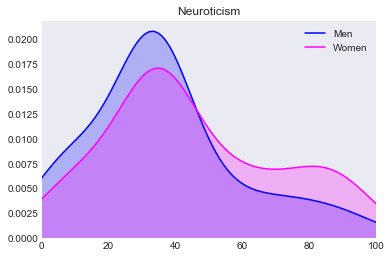

In [23]:
sns.kdeplot(men['BigFiveN'], bw=10, color='blue', shade=True)
sns.kdeplot(women['BigFiveN'], bw=10, color='magenta', shade=True)

plt.legend(['Men', 'Women'])
plt.xlim(0,100)
plt.title('Neuroticism')

Women do tend to score higher than men on neuroticism, but the bimodal distribution is odd.

# Religion

I've done a lot of religious/geographic analysis in the past and it's usually not that interesting because the differences tend to be pretty small. This dataset is no exception, but I'll include it since I'm sure a lot of people are curious.

In [24]:
# When performing comparisons, it's better NOT to use inferred values
data = pd.read_csv('ssc2018public_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]

In [25]:
# Converting religion back into a categorical variable
rels = data[[i for i in data.columns if "Denom" in i]].copy()

atheists = data[[i for i in data.columns if 'Ath' in i and 'but spiritual' not in i]].sum(axis=1)
rels['ReligiousDenomination_Atheist'] = pd.Series(np.where(atheists >= 1, 1., 0)).copy()
rels['ReligiousDenomination_Other'] = pd.Series(np.where(atheists >= 1, 0, rels['ReligiousDenomination_Other'])).copy()

rels = rels.idxmax(axis=1)

rels_vcs = rels.value_counts()
rels_vcs = rels_vcs[rels_vcs > 10]

rels = np.where(rels.isin(rels_vcs.index), rels, 'ReligiousDenomination_Other')

# Earlier, I lumped all religions with 10 or fewer people under "other"
data['Religion_categorial'] = pd.Series(rels)
data['Religion_categorial'].value_counts()

ReligiousDenomination_Atheist                                                  4007
ReligiousDenomination_Other                                                    1554
ReligiousDenomination_Christian (Protestant)                                    634
ReligiousDenomination_Christian (Catholic)                                      362
ReligiousDenomination_Jewish                                                    213
ReligiousDenomination_Buddhist                                                  113
ReligiousDenomination_Mixed/Other                                               107
ReligiousDenomination_Unitarian Universalism Or Similar                          82
ReligiousDenomination_Christian (Other Non-Protestant, Eg Eastern Orthodox)      72
ReligiousDenomination_Christian (Mormon)                                         53
ReligiousDenomination_Hindu                                                      41
ReligiousDenomination_Quaker                                                

The average life satisfaction of different religions...

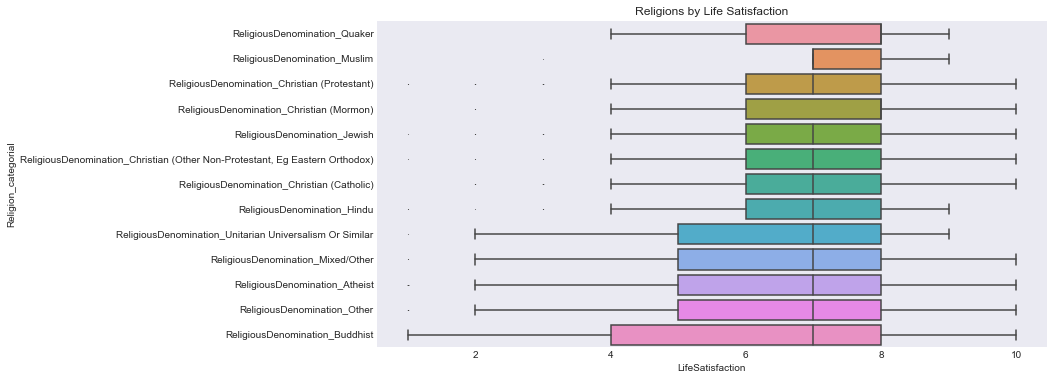

In [26]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').mean()['LifeSatisfaction'].sort_values(ascending=False).index
sns.boxplot(data['LifeSatisfaction'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Life Satisfaction')

In [27]:
# Comparing life satisfaction with a t-test
from scipy.stats import ttest_ind

def compare_top_and_bottom(col, order, top=0, bot=-1):
    df = data[data[col].notnull()]
    top_ix = order[top]
    bot_ix = order[bot]
    by = order.name
    
    if top == 0 and bot == -1:
        print('Highest ' + col + ': ' + top_ix)
        print('Lowest ' + col + ': ' + bot_ix)
    else:
        print('Comparing {} and {}'.format(top_ix, bot_ix))
    
    ttest = ttest_ind(df[df[by] == top_ix][col],
                      df[df[by] == bot_ix][col])
    return ttest
    
compare_top_and_bottom('LifeSatisfaction', order)

Highest LifeSatisfaction: ReligiousDenomination_Quaker
Lowest LifeSatisfaction: ReligiousDenomination_Buddhist


Ttest_indResult(statistic=1.2828635678820883, pvalue=0.20207540803630994)

There is **not** a statistically significant difference between the happiest religion (Quakers) and the unhappiest (Buddhists). I expected this, since I've seen several other datasets where Buddhists place first in happiness.

### Religions by Extraversion

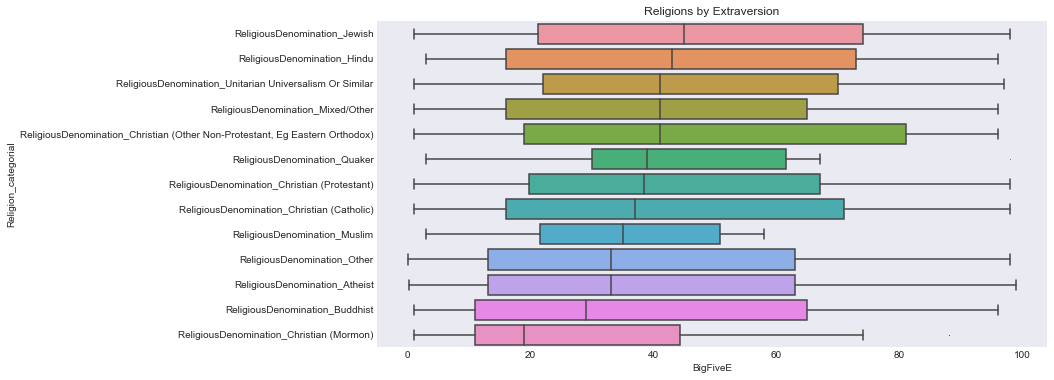

In [28]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveE'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveE'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Extraversion')

In [29]:
# Statistically significant
compare_top_and_bottom('BigFiveE', order)

Highest BigFiveE: ReligiousDenomination_Jewish
Lowest BigFiveE: ReligiousDenomination_Christian (Mormon)


Ttest_indResult(statistic=2.9761467858892279, pvalue=0.0034478008717579072)

### Religions by Openness to Experience

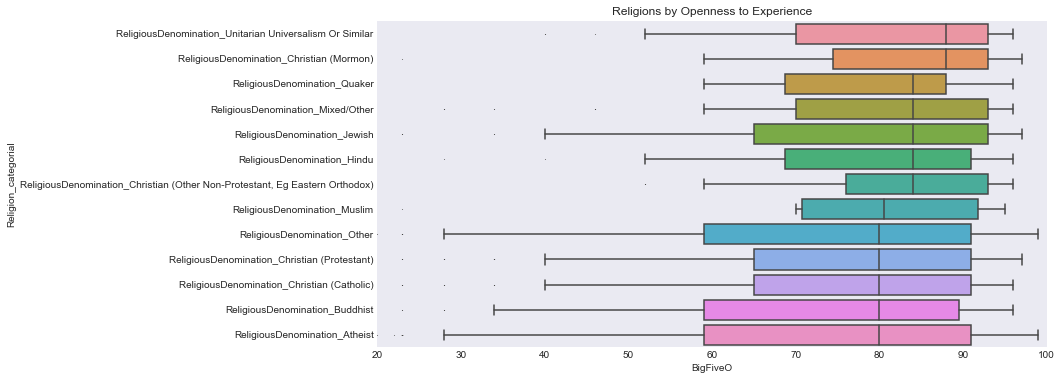

In [30]:
plt.figure(figsize=(12,6))
plt.xlim(20,100)

order = data.groupby('Religion_categorial').median()['BigFiveO'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveO'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Openness to Experience')

In [31]:
compare_top_and_bottom('BigFiveO', order)

Highest BigFiveO: ReligiousDenomination_Unitarian Universalism Or Similar
Lowest BigFiveO: ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.7152239692148843, pvalue=0.0066688904204366874)

So, SSC atheists are less open than Unitarians, which isn't all that surprising. But are they less open than, say, Protestants?

In [32]:
compare_top_and_bottom('BigFiveO', order, top=-4, bot=-1)
# Answer: Yes. SSC atheists score low in openness compared to other beliefs.

Comparing ReligiousDenomination_Christian (Protestant) and ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.1880336392866266, pvalue=0.028749066130254224)

Yep.

### Religions by Agreeableness

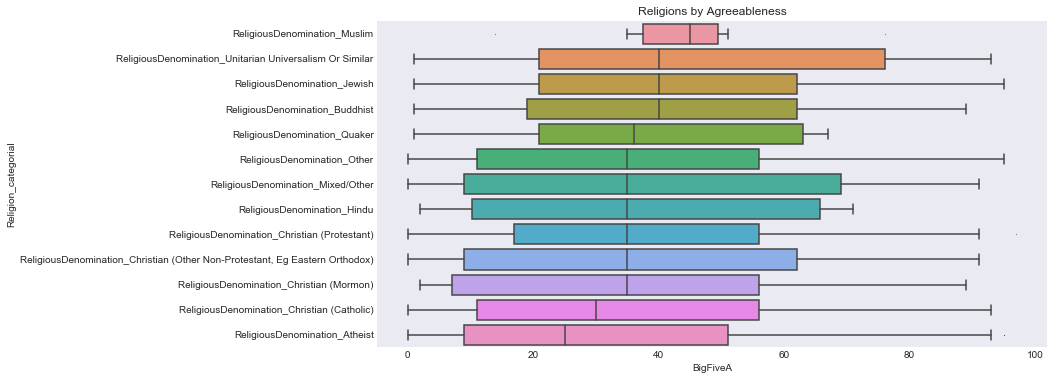

In [33]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveA'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveA'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Agreeableness')

In [34]:
compare_top_and_bottom('BigFiveA', order, top=-2)

Comparing ReligiousDenomination_Christian (Catholic) and ReligiousDenomination_Atheist


Ttest_indResult(statistic=2.0208807953734151, pvalue=0.043392675096182519)

SSC atheists are extremely disagreeable, on average. Even comparing them to the 2nd-most disagreeable group, Catholics, there's still a significant difference.

### Religions by Neuroticism

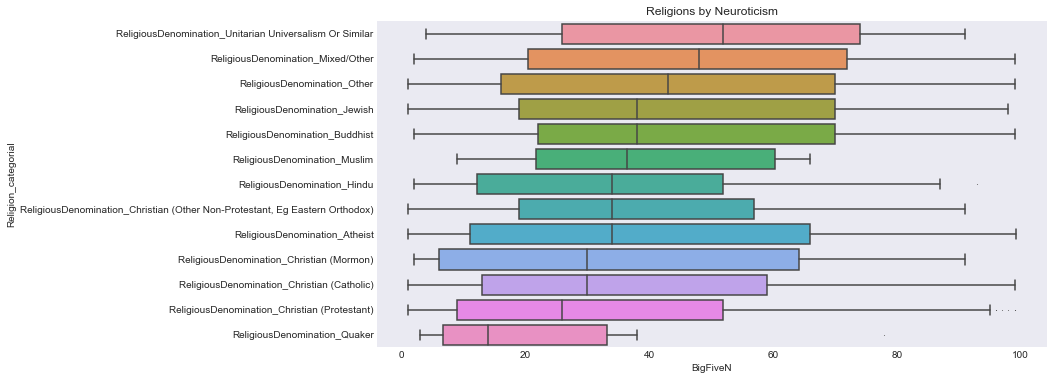

In [35]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveN'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveN'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Neuroticism')

Perhaps atheists should become Buddhist for their own mental health?

In [36]:
compare_top_and_bottom('BigFiveN', order, top=-9, bot=-5)

Comparing ReligiousDenomination_Buddhist and ReligiousDenomination_Atheist


Ttest_indResult(statistic=1.8430560324812235, pvalue=0.0654389533846787)

You could make a good argument for it.

### Religions by Conscientiousness

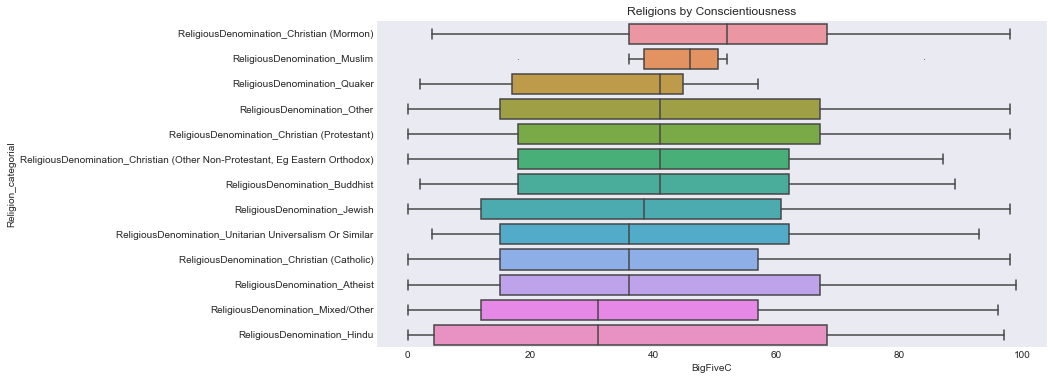

In [37]:
plt.figure(figsize=(12,6))

order = data.groupby('Religion_categorial').median()['BigFiveC'].sort_values(ascending=False).index
sns.boxplot(data['BigFiveC'], data['Religion_categorial'], whis=1, order=order, orient='h', fliersize=.2)
plt.title('Religions by Conscientiousness')

In [38]:
# Looks like the Mormon work ethic beats out the Protestant!
compare_top_and_bottom('BigFiveC', order, bot=4)

Comparing ReligiousDenomination_Christian (Mormon) and ReligiousDenomination_Christian (Protestant)


Ttest_indResult(statistic=1.666676460460965, pvalue=0.09635958014733155)

# Big Five Correlations

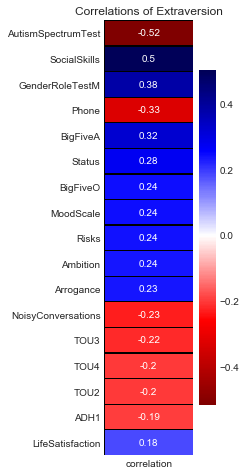

In [39]:
trait = absolute_correlations('BigFiveE', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Extraversion')

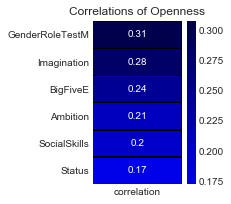

In [40]:
trait = absolute_correlations('BigFiveO', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Openness')

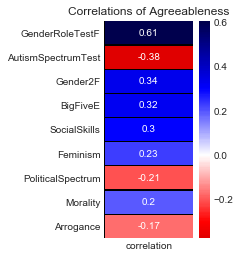

In [41]:
trait = absolute_correlations('BigFiveA', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Agreeableness')
# "PoliticalSpectrum" is how conservative you are.

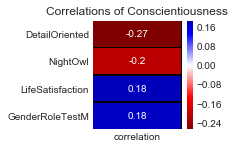

In [42]:
trait = absolute_correlations('BigFiveC', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Conscientiousness')
# DetailOriented must be "NOT detail-oriented." (I don't remember the exact question)

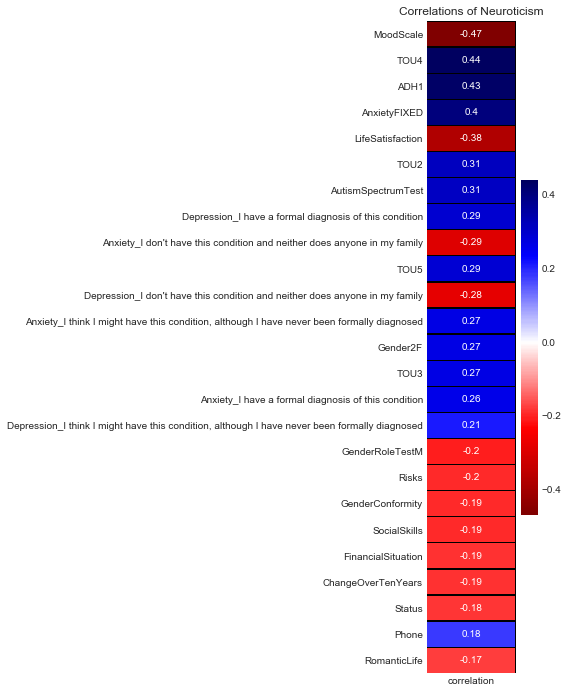

In [43]:
trait = absolute_correlations('BigFiveN', ascending=False)
corrmap(trait, cutoff=.17, title='Correlations of Neuroticism')

# Correlation Matrix

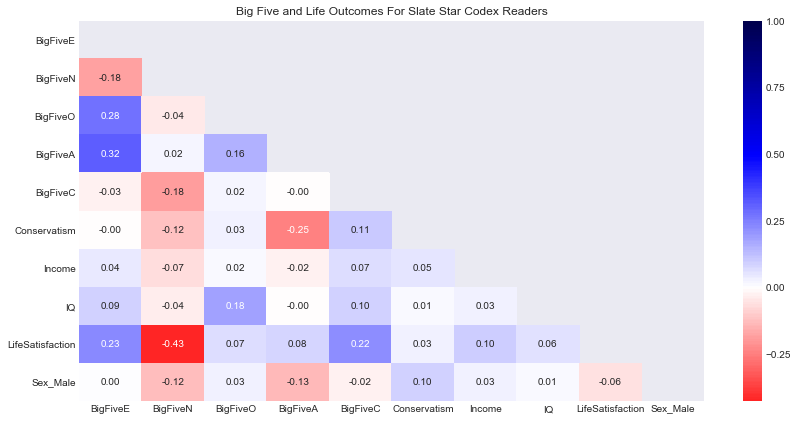

In [44]:
traits = data[['BigFiveE', 'BigFiveN', 'BigFiveO', 'BigFiveA', 'BigFiveC',
               'PoliticalSpectrum', 'Income', 'IQ', 'LifeSatisfaction', 'Sex_Male']]

# Clarifying and renaming PoliticalSpectrum
traits.rename(columns = {'PoliticalSpectrum':'Conservatism'}, inplace=True)

mask = np.zeros_like(traits.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14,7))
sns.heatmap(traits.corr(), annot=True, fmt='.2f', center=0, mask=mask, cmap='seismic_r')
plt.title('Big Five and Life Outcomes For Slate Star Codex Readers')